<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/otto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 05th August, 2020
Myfolder: C:\\Users\\ashok\\OneDrive\\Documents\\xgboost\\otto
          /home/ashok/Documents/8.otto

Ref:
https://www.kaggle.com/alexpengxiao/preprocessing-model-averaging-by-xgb-lgb-1-39

Objectives:
        i)   Using pandas and sklearn for modeling
        ii)  Feature engineering
                  a) Using statistical measures
                  c) Using binning/clustering
                  d) Using interaction variables
       iii)  Feature selection
                  a) Using derived feature importance from modeling
                  b) Using sklearn FeatureSelection Classes
        iv)  One hot encoding of categorical variables
         v)  Classifciation using RandomForest and stacked ensemble


# IMPT NOTE:
# See also:
#   https://github.com/ModelOriented/DALEX

Go through 'toy.py' first

""" 

In [316]:
# 1.0 Clear memory
#%reset -f

## A. Data manipulation

# 1.1 Call data manipulation libraries
import pandas as pd
import numpy as np


## B. Feature creation/manipulation

# 1.2 Feature creation Classes
from sklearn.preprocessing import PolynomialFeatures   # Interaction features
from sklearn.preprocessing import KBinsDiscretizer
# 1.2.1 BoxCox transformation
from sklearn.preprocessing import PowerTransformer     # BoxCox transformation
#from sklearn.preprocessing import KBinsDiscretizer    # Discretise continuous 
                                                       #   variable into K-bins

## C. Feature selection:

# 1.3 For feature selection
# Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  VarianceThreshold   # Remove constant-value columns

## D. Data preprocessing

# 1.4.1 Scaling data in various manner
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# 1.4.2 For encoding target class values
from sklearn.preprocessing import LabelEncoder

# 1.5 Splitting data
from sklearn.model_selection import train_test_split                # Returns split data
# 1.5.1
from sklearn.model_selection import StratifiedShuffleSplit          # Returns data indicies

## E. Pipelining

# 1.6 Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

## F: Estimators:

# 1.7 Modeling
# 1.7.1
from sklearn.utils.class_weight import compute_class_weight
# 1.7.2
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# 1.8 Performance metrics
from sklearn.metrics import  confusion_matrix,log_loss


## G: Others
# 1.9 Misc/visualization
import os, time, gc
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
# 1.11 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read data & reduce Memory

In [251]:
# 2.0 Set datafile path
path = "/content/"
os.chdir(path)

In [252]:
# 2.1 Read train file
train = pd.read_csv("train.csv.zip")

In [253]:
# 2.2 Look at data
train.shape                        # 61878 X 95
print()
train.head(2)
print()
train.dtypes.value_counts()        # All features are integers except target

(61878, 95)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1


int64     94
object     1
dtype: int64

In [254]:
# 2.3 Target classes--absolute vs normalized
train.target.value_counts()
print("\n\n--normalized--\n")
train.target.value_counts(normalize=True)

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64



--normalized--



Class_2    0.260545
Class_6    0.228433
Class_8    0.136785
Class_3    0.129351
Class_9    0.080077
Class_7    0.045881
Class_5    0.044265
Class_4    0.043489
Class_1    0.031174
Name: target, dtype: float64

In [255]:
# 2.4  Check if there are Missing/duplicate values? None
train.isnull().sum()            # None
train.isnull().sum().sum()      # None
train.duplicated().sum()        # None

id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64

0

0

In [256]:
# 2.5 Drop 'id' and save target column in another variable
train.drop(columns = ['id'] , inplace = True)
target = train.pop('target')   # Target

In [257]:
# 2.6 Memory usage
print("--Current memory usage (MB) --\n")
train.memory_usage().sum()/1000000  # 46.03736MB

# 2.6.1
print("\n\n--Max and min values---\n")
train.max().max()               # 352
print()
train.min().min()               # 0

# 2.6.2 Change dtype
train = train.astype('uint16')

# 2.6.3
print("\n\n--Revised memory usage (MB) --\n")
train.memory_usage().sum()/1000000  # 11.509436 MB

--Current memory usage (MB) --



46.03736



--Max and min values---



352

0



--Revised memory usage (MB) --



11.509436

### Process data

In [ ]:
# 3.1 We make one copy of data
#     We will use this copy while generating certain
#     statistical features
#X_stat = train.copy()

In [ ]:
# 3.2 Check if a categorical variable
#     exist. Any variable with levels
#     less than 10 would be a categorical
#     feature

#dg = train.nunique() < 10
print()
#dg.sum()  # 1
print()
#np.where(dg)[0]  # 5 the index
print()
#dg[np.where(dg)[0]]

In [ ]:
#train['feat_6'].value_counts()

0     60710
1       883
2       201
3        57
5        14
4        10
10        1
8         1
6         1
Name: feat_6, dtype: int64

In [ ]:
#train.loc[train['feat_6'].isin([10,8,4,6]), 'feat_6'] = 11
#train['feat_6'].value_counts()

0     60710
1       883
2       201
3        57
5        14
11       13
Name: feat_6, dtype: int64

In [270]:
# 4.0 Encode classes
le = LabelEncoder()           # Instantiate LabelEncoder
y =le.fit_transform(target)   # Fit and transform 'y'
y

array([0, 0, 0, ..., 8, 8, 8])

In [259]:
# How has transformation been done:
le.classes_
print(); print()
dict(zip(le.classes_, le.transform(le.classes_)))

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

{'Class_1': 0,
 'Class_2': 1,
 'Class_3': 2,
 'Class_4': 3,
 'Class_5': 4,
 'Class_6': 5,
 'Class_7': 6,
 'Class_8': 7,
 'Class_9': 8}

#### Compute class weights

If ‘balanced’, class weights will be given by `n_samples / (n_classes * np.bincount(y))`. For example if number of samples are 61878, n_classes are 9, and number of value_counts for class_1 are 1929, then weight will be: `(61878/9)/ 1929 = 3. 5641`. `np.bincount(y)` and `y.value_counts()` give same results. 

In [275]:
# How much importance be give nto a class?
weights = compute_class_weight('balanced', np.unique(y), y)
weights    # Corresponds to class_1, class_2, ...class_9

array([3.56419561, 0.4264566 , 0.85898717, 2.55493621, 2.51016186,
       0.48640491, 2.42174475, 0.81230309, 1.38755466])

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(
                                                   train,
                                                   y,
                                                   test_size = 0.3,
                                                   stratify = y,
                                                   shuffle= True)

X_train.shape  # (43314, 93)
X_test.shape   # (18564, 93)

In [298]:
pipe1 = make_pipeline(
                      StandardScaler(),       # pipe1[0]
                      rf(                     # pipe1[1]
                          n_estimators=100,
                          max_depth = 35,
                          class_weight = c_weights,
                          oob_score = True
                         )
                      )

In [299]:
pipe1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight={0: 3, 1: 1, 2: 1, 3: 1,
                                                      4: 1, 5: 1, 6: 1, 7: 1,
                                                      8: 1},
                                        criterion='gini', max_depth=35,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n

In [300]:
prob_orig = pipe1.predict_proba(X_test)
prob_orig.shape   # (18564, 9)

(18564, 9)

In [301]:
class_names = ['class_1','class_2','class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
pr = pd.DataFrame(prob_orig, columns = class_names)
pr.head()

,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,0.030000,0.080000,0.050000,0.000000,0.000000,0.160000,0.550000,0.110000,0.020000
1,0.000103,0.488806,0.264564,0.235688,0.000000,0.000034,0.010737,0.000034,0.000034
2,0.015132,0.079762,0.038965,0.084230,0.061301,0.621667,0.015994,0.031906,0.051043
3,0.009096,0.715531,0.089954,0.034541,0.000058,0.025118,0.031551,0.031076,0.063076
4,0.000000,0.000000,0.000000,0.010000,0.000000,0.970000,0.020000,0.000000,0.000000


In [302]:
# How much is logloss
log_loss(y_test,prob_orig)         # 0.602429785704475

0.5919525007287527

In [303]:
# What is oob_score:
pipe1[1].oob_score_   # 0.7969247818257377

0.7964399501315972

In [ ]:
pipe1[1].feature_importances_

In [307]:
# Ref: https://stackoverflow.com/a/613228/3282777
from operator import itemgetter
d = dict(zip(train.columns,clf_orig.feature_importances_))
result = sorted(d.items(), key=itemgetter(1))
print(result)
cols = [i[0] for i in result]
print(cols)

[('feat_1', 0.0009900891211233667), ('feat_2', 0.001165844869134619), ('feat_3', 0.0015613255183094545), ('feat_4', 0.0018927804179026501), ('feat_5', 0.002188784389965658), ('feat_6', 0.002297575883932163), ('feat_8', 0.0023449513217658805), ('feat_7', 0.002559257210495926), ('feat_10', 0.0026535364965640427), ('feat_9', 0.002676995800850457), ('feat_11', 0.0027196406259812505), ('feat_16', 0.0030633656651445356), ('feat_12', 0.0033085171163885403), ('feat_13', 0.0034097612341385617), ('feat_15', 0.0034551622318690217), ('feat_19', 0.0035363852574481895), ('feat_17', 0.0037596137159380933), ('feat_18', 0.003846908695002929), ('feat_14', 0.003966820804124264), ('feat_22', 0.004283059042085052), ('feat_21', 0.004606032365163905), ('feat_20', 0.004695485244330345), ('feat_23', 0.004889309874538221), ('feat_26', 0.00511954099914908), ('feat_24', 0.005152306291321542), ('feat_25', 0.0053103019977904994), ('feat_27', 0.005523596404365901), ('feat_28', 0.005551934080873804), ('feat_29', 0.00

In [322]:
pipe2 = make_pipeline(
                      StandardScaler(),
                      PowerTransformer(),
                      rf(                    
                          n_estimators=100,
                          max_depth = 35,
                          class_weight = c_weights,
                          oob_score = True
                         )
                       )

In [ ]:
pipe2.fit(X_train,y_train)
prob_tr = pipe2.predict_proba(X_test)
prob_tr.shape   # (18564, 9)
# How much is logloss
log_loss(y_test,prob_tr)         # 0.602429785704475

In [327]:
pipe3 = make_pipeline(
                       StandardScaler(),
                       ExtraTreesClassifier(n_estimators=300)
                      )

In [328]:
pipe3.fit(X_train,y_train)
prob_ex = pipe3.predict_proba(X_test)
prob_ex.shape   # (18564, 9)
# How much is logloss
log_loss(y_test,prob_ex)         # 0.602429785704475

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=300, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

(18564, 9)

0.6027103778411553

In [329]:
estimators = [
               ("pipe1", pipe1),
               ("pipe2",pipe2),
               ("pipe3",pipe3),
              ]

clf_vote = VotingClassifier(
                               estimators=estimators,
                               voting = "soft",
                               n_jobs = -1
                               )


In [330]:
clf_vote.fit(X_train, y_train)
prob_vt = clf_vote.predict_proba(X_test)
log_loss(y_test,prob_vt)         # 0.6069367467472497 0.6166262332908614

VotingClassifier(estimators=[('pipe1',
                              Pipeline(memory=None,
                                       steps=[('standardscaler',
                                               StandardScaler(copy=True,
                                                              with_mean=True,
                                                              with_std=True)),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      class_weight={0: 3,
                                                                                    1: 1,
                                                                                    2: 1,
                                                                                    3: 1,
          

0.5858984055139382

###PowerTransformer

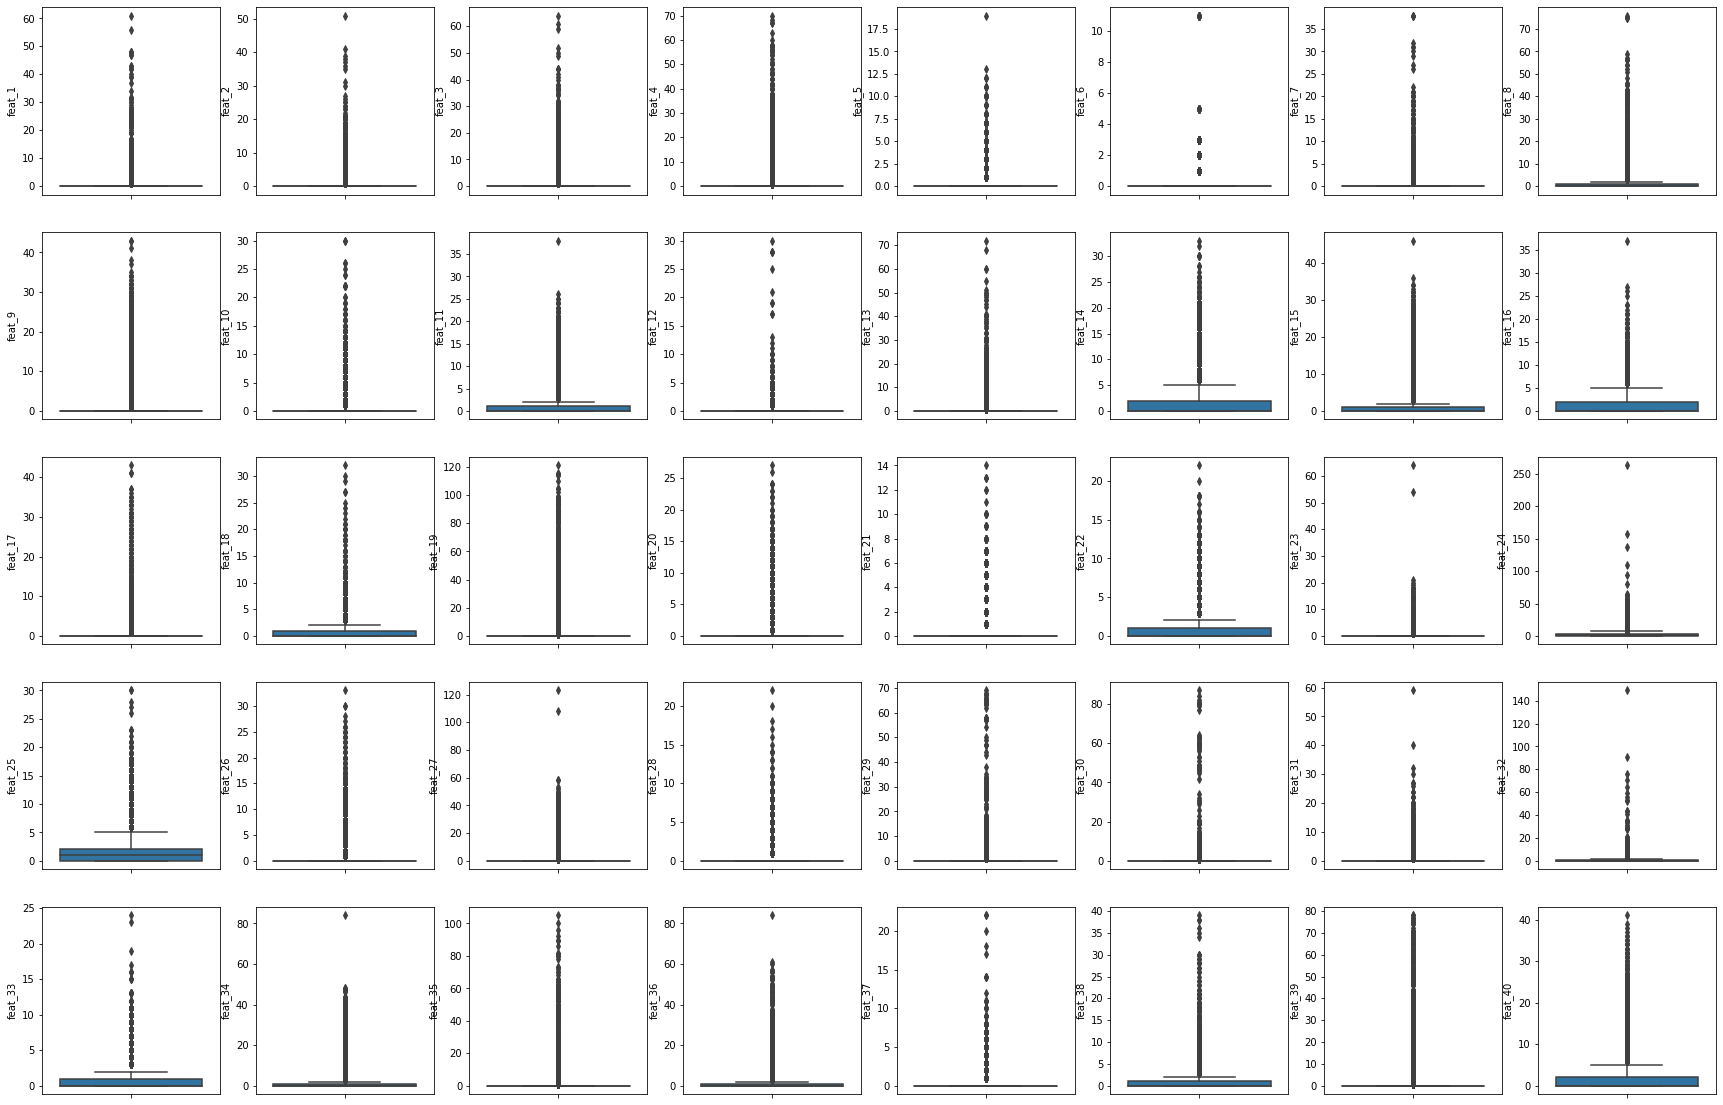

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(0,40):
    name = 'feat_' + str(i+1)
    _=plt.subplot(5,8,i+1)
    _=sns.boxplot(y = train[name])


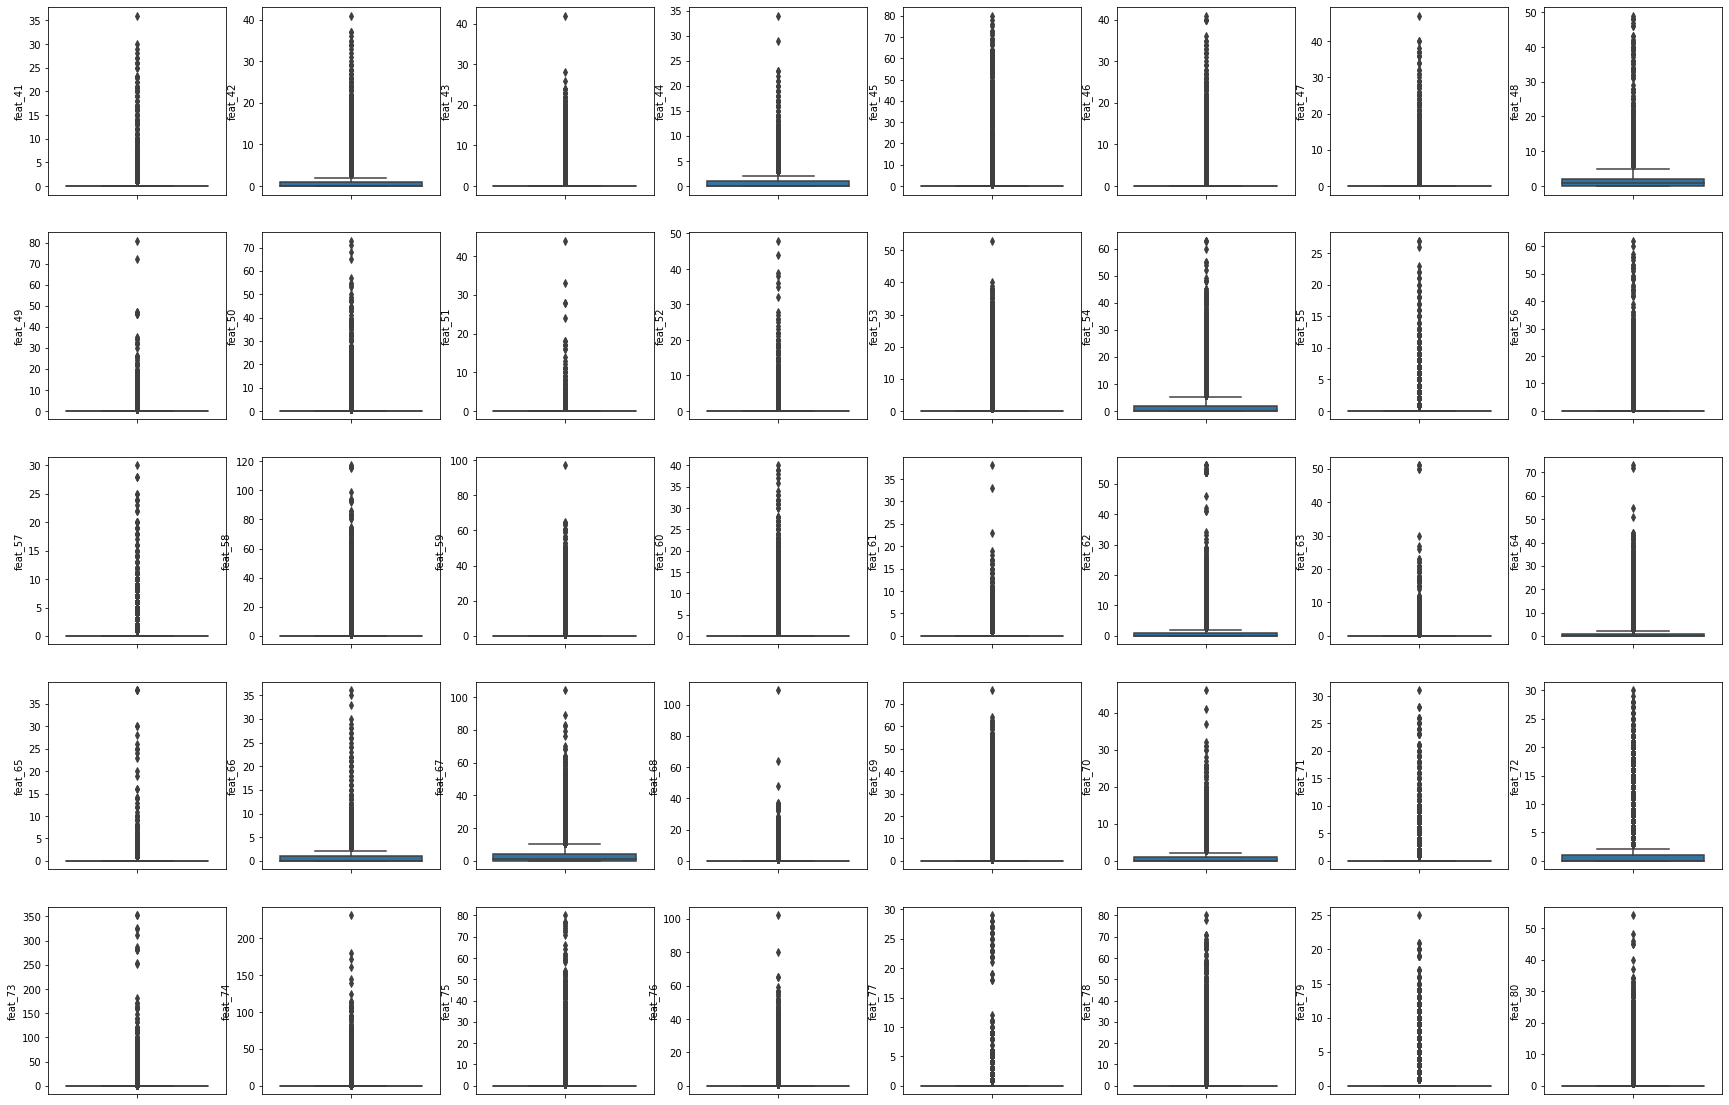

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(41, 81):
    j = i - 40
    name = 'feat_' + str(i)
    _=plt.subplot(5,8,j)
    _=sns.boxplot(y = train[name])


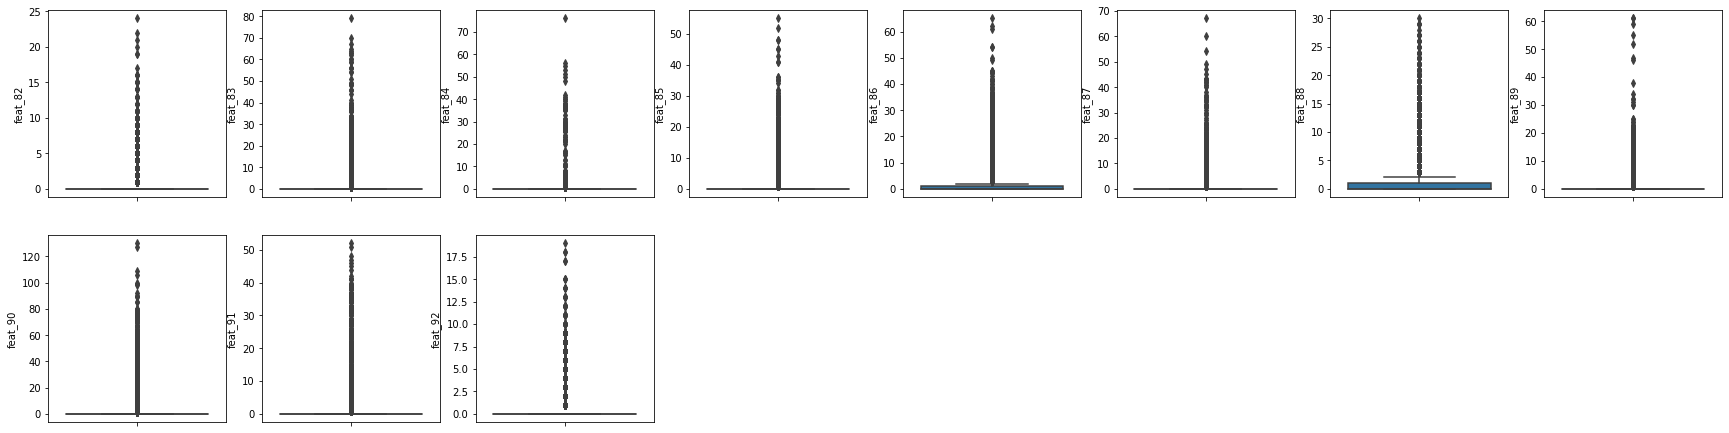

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(82, 93):
    j = i - 81
    name = 'feat_' + str(i)
    _=plt.subplot(5,8,j)
    _=sns.boxplot(y = train[name])

In [ ]:
from sklearn.preprocessing import power_transform
x_train = power_transform(train, method='yeo-johnson')
x_train = pd.DataFrame(x_train, columns = train.columns)

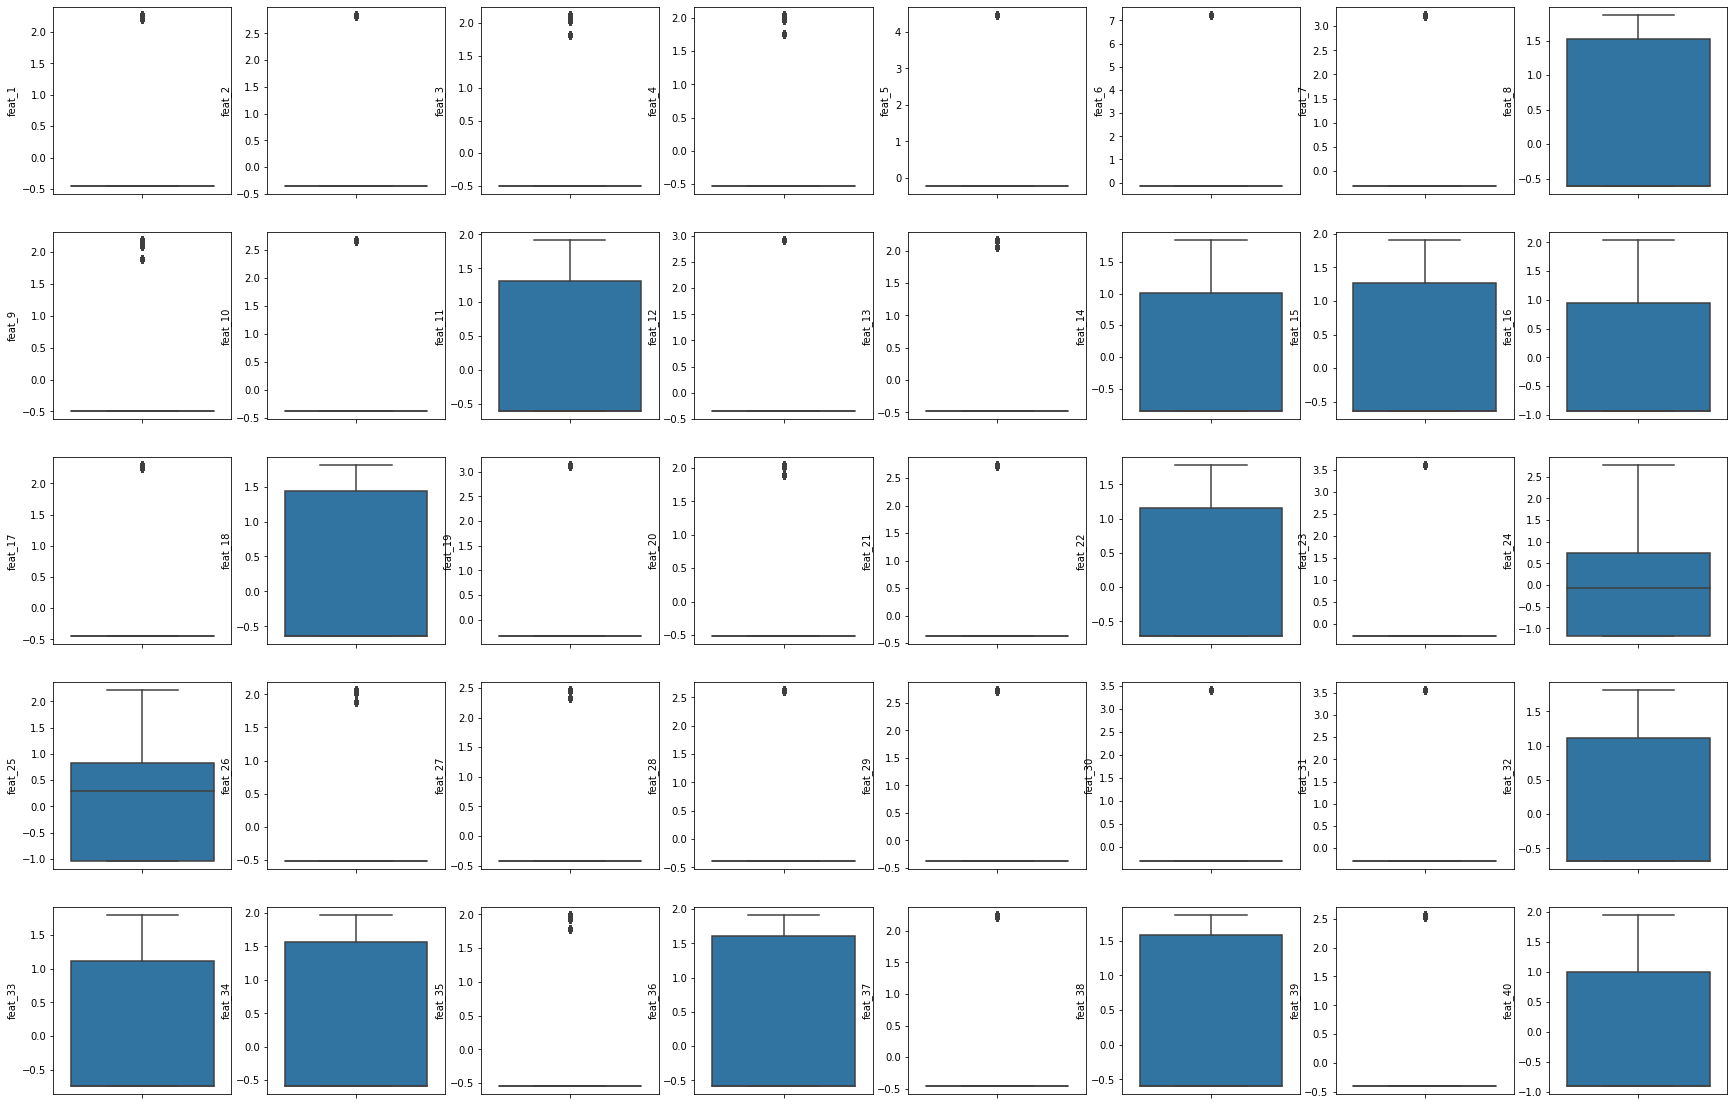

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(0,40):
    name = 'feat_' + str(i+1)
    _=plt.subplot(5,8,i+1)
    _=sns.boxplot(y = x_train[name])


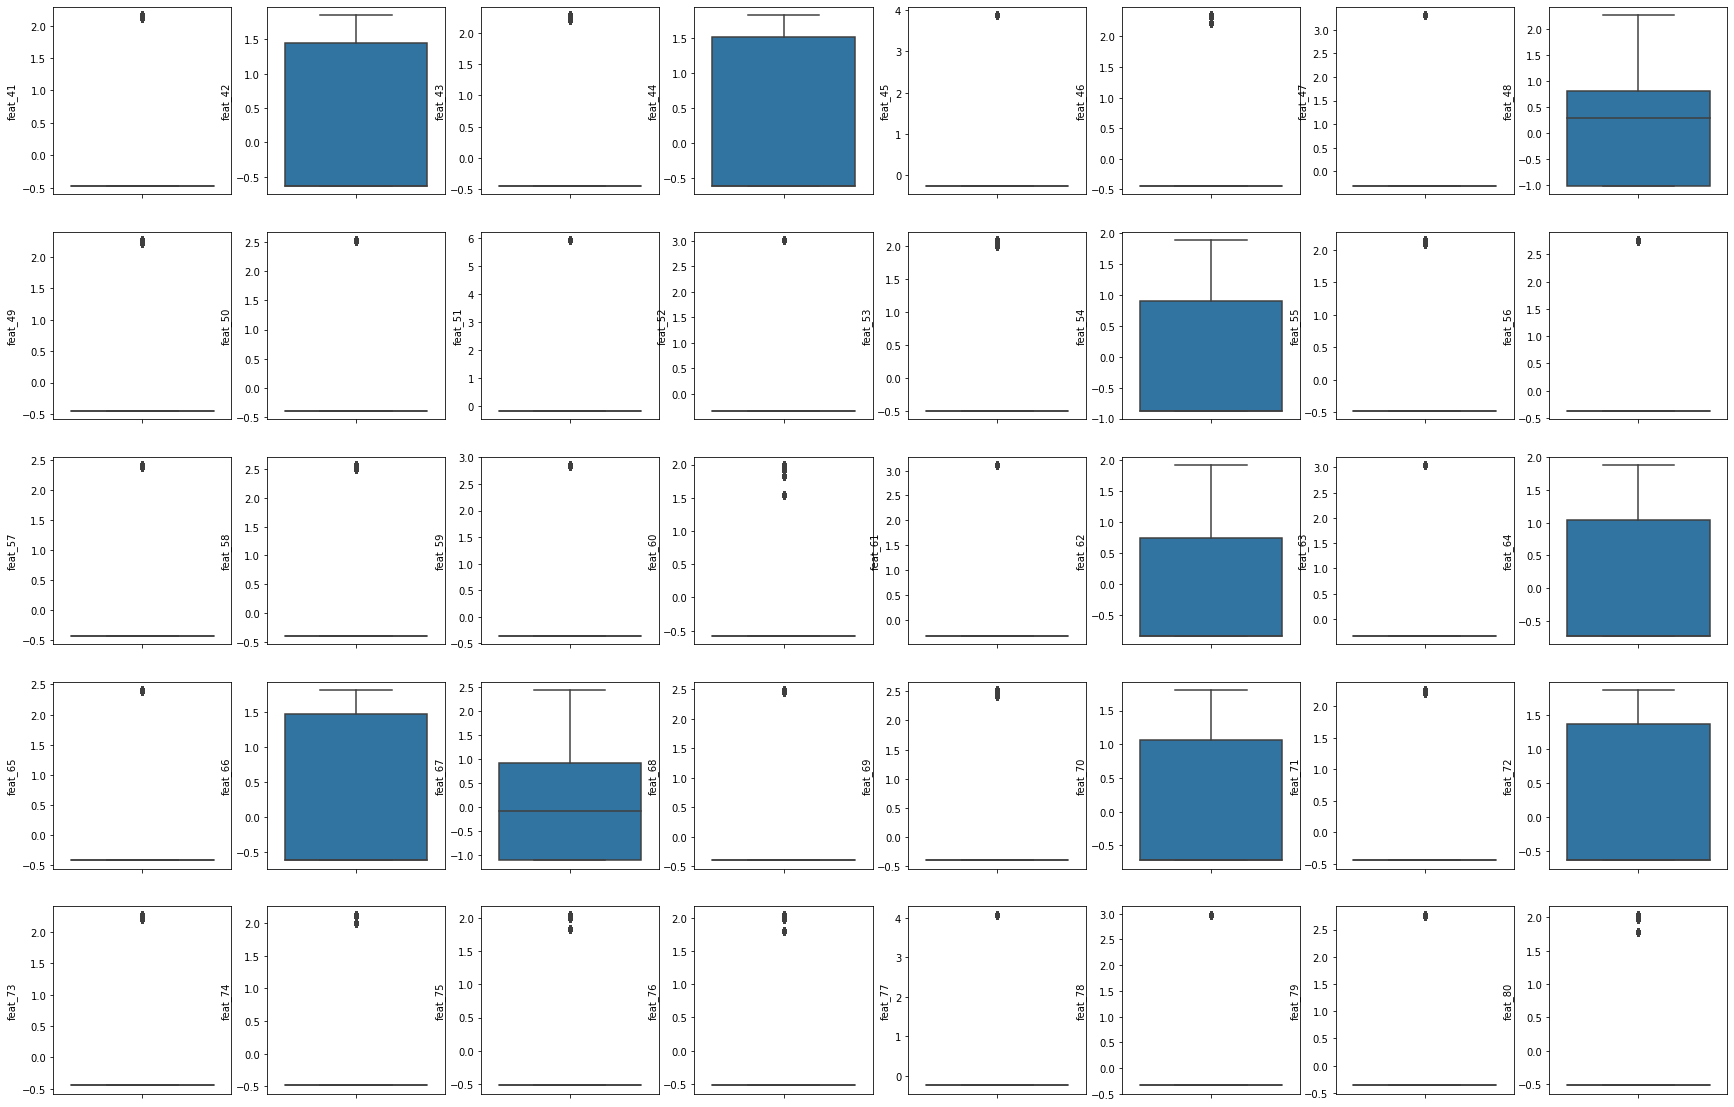

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(41, 81):
    j = i - 40
    name = 'feat_' + str(i)
    _=plt.subplot(5,8,j)
    _=sns.boxplot(y = x_train[name])


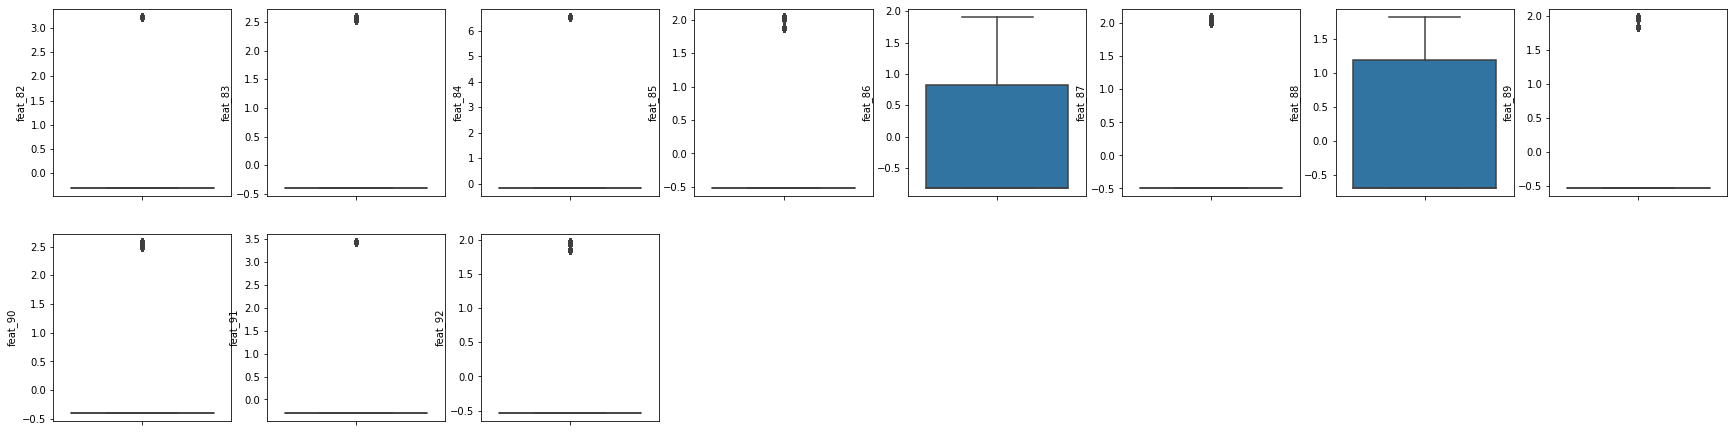

In [ ]:
# 5.0 How should we scale data?
#     Let us draw box-plots to decide
#     There are a number of outliers
fig = plt.figure(figsize=(30,20))
for i in range(82, 93):
    j = i - 81
    name = 'feat_' + str(i)
    _=plt.subplot(5,8,j)
    _=sns.boxplot(y = x_train[name])

In [ ]:
colsToTransf = ["feat_8","feat_11","feat_14","feat_15","feat_16","feat_18","feat_22","feat_24","feat_25","feat_32","feat_33","feat_34","feat_36","feat_38","feat_40","feat_42","feat_44","feat_48","feat_54","feat_62","feat_64","feat_66","feat_67","feat_70","feat_72","feat_86","feat_87"]

In [ ]:
xy = power_transform(x_train[colsToTransf], method='yeo-johnson')
x_train[colsToTransf] = pd.DataFrame(xy, columns = colsToTransf)

NameError: ignored

In [ ]:
x_train.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,2.200366,-0.353109,-0.504266,-0.525630,-0.224578,-0.138705,-0.310309,-0.604623,-0.490675,-0.376517,1.590188,-0.34366,-0.476368,-0.875986,-0.643001,-0.950731,2.285623,-0.636451,-0.320253,-0.511338,-0.366688,1.329405,-0.276949,0.969492,0.372180,1.878623,-0.413831,-0.381703,2.726879,-0.294131,-0.281355,-0.688434,-0.744441,-0.583211,1.778223,-0.578669,-0.449417,-0.592901,-0.392874,0.684128,...,0.672425,-0.474409,-0.363048,2.405337,-0.394543,-0.351254,1.985895,-0.321693,0.930708,3.044444,-0.736204,2.393717,-0.628574,1.258683,-0.405387,-0.404522,-0.732353,2.212989,-0.63745,-0.448168,-0.486072,-0.523004,-0.524833,-0.245744,-0.336800,2.766544,1.785607,-0.232872,-0.310341,-0.391109,-0.153422,1.877117,-0.828219,-0.490978,-0.685208,-0.531266,-0.394530,-0.291561,-0.530411,-0.253849
1,-0.449314,-0.353109,-0.504266,-0.525630,-0.224578,-0.138705,-0.310309,1.638698,-0.490675,-0.376517,-0.611235,-0.34366,-0.476368,-0.875986,-0.643001,-0.950731,-0.442425,1.591219,-0.320253,-0.511338,-0.366688,-0.716364,-0.276949,-1.186857,-1.058076,-0.507773,-0.413831,-0.381703,-0.367340,-0.294131,-0.281355,-0.688434,-0.744441,-0.583211,-0.535937,-0.578669,2.216012,-0.592901,-0.392874,-0.925905,...,-0.899372,-0.474409,-0.363048,-0.418513,2.496971,-0.351254,-0.573147,-0.321693,-0.857223,-0.328439,1.260452,-0.417158,-0.628574,-0.015552,-0.405387,-0.404522,-0.732353,-0.449073,-0.63745,2.261506,2.004146,-0.523004,1.797650,-0.245744,2.966511,-0.362334,-0.522858,-0.232872,-0.310341,-0.391109,-0.153422,-0.514540,-0.828219,-0.490978,-0.685208,-0.531266,-0.394530,-0.291561,-0.530411,-0.253849
2,-0.449314,-0.353109,-0.504266,-0.525630,-0.224578,-0.138705,-0.310309,1.638698,-0.490675,-0.376517,-0.611235,-0.34366,-0.476368,-0.875986,-0.643001,-0.950731,2.241600,-0.636451,-0.320253,-0.511338,-0.366688,-0.716364,-0.276949,-1.186857,-1.058076,-0.507773,-0.413831,-0.381703,-0.367340,-0.294131,-0.281355,-0.688434,1.271512,-0.583211,-0.535937,-0.578669,-0.449417,-0.592901,-0.392874,-0.925905,...,-0.899372,2.089917,-0.363048,-0.418513,-0.394543,-0.351254,-0.573147,-0.321693,-0.857223,-0.328439,-0.736204,-0.417158,-0.628574,1.170687,-0.405387,-0.404522,1.400350,-0.449073,-0.63745,-0.448168,-0.486072,-0.523004,-0.524833,-0.245744,-0.336800,-0.362334,-0.522858,4.294199,-0.310341,-0.391109,-0.153422,-0.514540,-0.828219,-0.490978,-0.685208,-0.531266,-0.394530,-0.291561,-0.530411,-0.253849
3,2.200366,-0.353109,-0.504266,1.760039,4.452789,7.209559,3.223416,-0.604623,-0.490675,2.651004,1.590188,-0.34366,2.062458,-0.875986,-0.643001,0.604668,2.241600,-0.636451,-0.320253,-0.511338,-0.366688,-0.716364,-0.276949,1.336092,0.864355,2.021803,-0.413831,-0.381703,-0.367340,3.399947,-0.281355,1.530518,-0.744441,-0.583211,-0.535937,-0.578669,-0.449417,1.703405,-0.392874,-0.925905,...,1.158482,2.089917,-0.363048,-0.418513,-0.394543,-0.351254,-0.573147,-0.321693,-0.857223,-0.328439,-0.736204,2.406011,1.571238,1.061957,-0.405387,-0.404522,1.459706,-0.449073,-0.63745,2.261506,2.004146,-0.523004,1.797650,-0.245744,-0.336800,2.753144,1.785607,4.294200,3.223133,-0.391109,6.517990,-0.514540,1.019691,2.038335,-0.685208,-0.531266,-0.394530,-0.291561,-0.530411,-0.253849
4,-0.449314,-0.353109,-0.504266,-0.525630,-0.224578,-0.138705,-0.310309,-0.604623,-0.490675,-0.376517,-0.611235,-0.34366,-0.476368,-0.875986,-0.643001,-0.950731,2.289994,-0.636451,-0.320253,-0.511338,-0.366688,-0.7163

### Pipes

In [ ]:
pipe1 = make_pipeline(StandardScaler(), PowerTransformer(), rf(max_depth =30))
pipe2 = make_pipeline(StandardScaler(), rf(max_depth =30))
#pipe3 = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
#pipe4 = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB())
pipe5 = make_pipeline(StandardScaler(), LogisticRegression( multi_class="multinomial", max_iter = 8000))
pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False),VarianceThreshold(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe4 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf())


In [ ]:
pipe1 = make_pipeline(StandardScaler(), PowerTransformer(), rf(max_depth =30))
pipe2 = make_pipeline(StandardScaler(), rf(max_depth =30))
#pipe3 = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
#pipe4 = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB())
pipe5 = make_pipeline(StandardScaler(), LogisticRegression( multi_class="multinomial", max_iter = 8000))
#pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False),VarianceThreshold(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe4 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf())


In [ ]:
pipe1 = make_pipeline(StandardScaler(), PowerTransformer(), rf(max_depth =30))
pipe2 = make_pipeline(StandardScaler(), rf(max_depth =30))
#pipe3 = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe5 = make_pipeline(StandardScaler(), LogisticRegression( multi_class="multinomial", max_iter = 8000))
#pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False),VarianceThreshold(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe4 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf(n_estimators = 300))



In [ ]:
pipe1 = make_pipeline(StandardScaler(), PowerTransformer(), rf(max_depth =30))
pipe2 = make_pipeline(StandardScaler(), rf(max_depth =30))
#pipe3 = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
#pipe4 = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB())
pipe5 = make_pipeline(StandardScaler(), LogisticRegression( multi_class="multinomial", max_iter = 8000))
#pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False),VarianceThreshold(), ExtraTreesClassifier(n_estimators=300, max_depth =30))
pipe4 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=False, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf(n_estimators = 300))
pipe3 = make_pipeline(StandardScaler(), PolynomialFeatures(2,interaction_only=True, include_bias = False), VarianceThreshold(),SelectKBest(k=200),  rf(n_estimators = 100))


In [ ]:
pipe5.fit(train,y)

In [ ]:
pipe5.predict(train)

array([0, 0, 0, ..., 8, 5, 8])

In [ ]:
# 10.0
degree = 2
poly = PolynomialFeatures(degree,                 # Degree 2
                          interaction_only=False,  # Avoid e.g. square(a)
                          include_bias = False    # No constant term
                          )

# 10.1
pol_features =  poly.fit_transform(x_train)        # To limit features, use X[:, :40]
pol_features.shape     #  (61878, 4371)
pol_features


# 10.2 Are there any features with constant columns
selector = VarianceThreshold()
# 10.2.1
selector.fit(pol_features)
# 10.2.2
X_poly = selector.transform(pol_features)
print()
X_poly.shape           # (61878, 4371)
print()
# 10.3
del pol_features
gc.collect()


In [ ]:

impt_features = SelectKBest(
                            k=2500           # Default k = 10
                            )
# 11.1
impt_features.fit(X_poly,y)
# 11.2
impt_features = impt_features.transform(X_poly)
# 11.3
impt_features.shape    # (61878, 2500)
###################


SelectKBest(k=2500, score_func=<function f_classif at 0x7f4c3d038b90>)

(61878, 2500)

In [151]:
# 12.1 Split train into training and validation dataset. Statistical features
# https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#:~:text=Stratified%20ShuffleSplit%20cross-validator%20Provides%20train%2Ftest%20indices%20to%20split,preserving%20the%20percentage%20of%20samples%20for%20each%20class.
sss = StratifiedShuffleSplit(                      # Perform stratified sampling on 'y'
                             n_splits=1,           # How many split-pairs of Xtrain/Xtest
                             test_size=0.3
                             )

# 12.2 Get just indicies of data to be pulled

X_train_index, X_test_index = next(sss.split(train, y))      # sss.split() is a generator object


In [152]:
X_orig_train,X_orig_test  = train.loc[X_train_index, :],train.loc[X_test_index,:]  

In [ ]:
X_poly_train, X_poly_test = X_poly[X_train_index], X_poly[X_test_index] 

In [ ]:
X_stat_train,X_stat_test  = x_train.iloc[X_train_index], x_train.iloc[X_test_index]

In [ ]:
X_impt_train,X_impt_test  = impt_features[X_train_index], impt_features[X_test_index]  

In [153]:
## 12.4 Partitions of target column
y_train, y_test = y[X_train_index], y[X_test_index]

# 12.5
X_orig_train.shape    # (43314, 4371)
X_orig_test.shape     # (18564, 4371)
#X_poly_train.shape


(43314, 93)

(18564, 93)

In [ ]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

In [ ]:
estimators = [pipe1,pipe2,pipe3,pipe4]
    ('rf', rf(n_estimators=100)),
    ('log', LogisticRegression(max_iter = 8000) ),
    #("rid", RidgeClassifier()),
    ('nb', LinearSVC(dual = False))
    
]
clf_stack = StackingClassifier(
    estimators=estimators, final_estimator=rf(n_estimators=100)
)
clf_stack.fit(X_orig_train, y_train)
prob_orig = clf_stack.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

In [ ]:
estimators = [
               ("pipe1", pipe1),
               ("pipe2",pipe2),
               ("pipe3",pipe3),
               ("pipe4",pipe4),
               ("pipe5",pipe5),
              ]

clf_stack = StackingClassifier(
                               estimators=estimators,
                               final_estimator=rf(n_estimators=100),
                               verbose =1,
                               n_jobs = -1
                               )



In [ ]:
estimators = [
               ("pipe1", pipe1),
               ("pipe2",pipe2),
               #("pipe3",pipe3),
               ("pipe4",pipe4),
               ("pipe5",pipe5),
              ]

clf_vote = VotingClassifier(
                               estimators=estimators,
                               voting = "soft",
                               n_jobs = -1
                               )



In [ ]:
clf_stack.fit(X_orig_train, y_train)
prob_orig = clf_stack.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

In [ ]:
clf_vote.fit(X_orig_train, y_train)
prob_orig = clf_vote.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

In [ ]:
## 13. With Polynomial features
#  13.1 Instantiate RandomForest classifier
clf_poly_rf = rf(n_estimators=10)

# 13.2 Fit/train the object on training data
clf_poly_rf = clf_poly_rf.fit(X_poly_train, y_train)
# 13.3  Use model to make predictions
classes_poly_rf = clf_poly_rf.predict(X_poly_test)
# 13.4 Probability predictios
prob_poly     = clf_poly_rf.predict_proba(X_poly_test)
prob_poly.shape    # (18564, 9)
# 13.5 Check log loss
log_loss( y_test,prob_poly)     # 0.6263 0.6546697859585899 0.6627180577198296


(18564, 9)

1.6939458611762608

In [ ]:
## 14. Impt k-features from polynomial features
clf_impt = rf(n_estimators=100)
clf_impt = clf_impt.fit(X_impt_train, y_train)
prob_impt = clf_impt.predict_proba(X_impt_test)
log_loss( y_test,prob_impt)         # 0.6626970448421848 0.6713134574542247


0.6449464676517388

In [75]:
target.value_counts()
print("\n\n")
dict(zip(np.unique(y)+1,weights))

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64

{1: 3.5641956108519093,
 2: 0.4264566017450275,
 3: 0.8589871730801266,
 4: 2.5549362071101203,
 5: 2.51016185955945,
 6: 0.4864049050819479,
 7: 2.4217447458025125,
 8: 0.8123030875866415,
 9: 1.3875546585940128}

In [76]:
c_weights = dict(zip(np.unique(y),weights))
c_weights

{0: 3.5641956108519093,
 1: 0.4264566017450275,
 2: 0.8589871730801266,
 3: 2.5549362071101203,
 4: 2.51016185955945,
 5: 0.4864049050819479,
 6: 2.4217447458025125,
 7: 0.8123030875866415,
 8: 1.3875546585940128}

In [223]:
c_weights = dict(zip(np.unique(y),[3,1,1,1,1,1,1,1,1]))
c_weights

{0: 3, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}

In [ ]:
## 18. Original features
#c_weights = "balanced_subsample"
clf_orig = rf(
               n_estimators=100,
               max_depth = 35,
               class_weight = c_weights,
               oob_score = True
              )
clf_orig.fit(X_orig_train[cols[0:]], y_train)
prob_orig = clf_orig.predict_proba(X_orig_test[cols[0:]])
print()
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614
print()


In [248]:
# Accuracy on OOB samples
clf_orig.oob_score_

0.7980560557787321

In [234]:
d = dict(zip(train.columns,clf_orig.feature_importances_))

In [ ]:
# Ref: https://stackoverflow.com/a/613228/3282777
from operator import itemgetter
d = dict(zip(train.columns,clf_orig.feature_importances_))
result = sorted(d.items(), key=itemgetter(1))
result
cols = [i[0] for i in result]
cols

In [213]:
test = X_orig_test.copy()
test['target'] = y_test

In [214]:
test['pred'] = clf_orig.predict(test.iloc[:,:-1])


In [215]:
confusion_matrix(test['target'],test['pred'])

array([[ 265,   30,    1,    1,    3,   45,   11,  100,  123],
       [   2, 4315,  435,   24,    8,   14,   22,    7,   10],
       [   2, 1266, 1077,   23,    0,    3,   14,   11,    5],
       [   1,  352,  110,  306,    3,   30,    5,    0,    0],
       [   4,   20,    0,    0,  797,    1,    0,    0,    0],
       [  13,   48,    4,    7,    1, 4022,   40,   67,   39],
       [  16,  115,   64,    3,    7,   81,  456,   99,   11],
       [  24,   25,    8,    0,    1,   69,   11, 2362,   39],
       [  38,   40,    1,    0,    3,   45,    5,   54, 1300]])

In [205]:
test['target'].value_counts()

1    4837
5    4241
7    2539
2    2401
8    1486
6     852
4     822
3     807
0     579
Name: target, dtype: int64

In [ ]:
## 18. Original features
pipe1.fit(X_orig_train, y_train)
prob_orig = pipe1.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

In [ ]:
## 18. Original features
pipe2.fit(X_orig_train, y_train)
prob_orig = pipe2.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

0.6128318263285067

In [ ]:
## 18. Original features
pipe3.fit(X_orig_train, y_train)
prob_orig = pipe3.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)      

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=300, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

0.6028930683621544

In [ ]:
## 18. Original features
pipe4.fit(X_orig_train, y_train)
prob_orig = pipe4.predict_proba(X_orig_test)
log_loss(y_test,prob_orig) 

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('powertransformer',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=30, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=300, n_jobs=None,
                             

0.6499708300379367

In [ ]:
## 18. Original features
pipe4.fit(X_orig_train, y_train)
prob_orig = pipe4.predict_proba(X_orig_test)
log_loss(y_test,prob_orig)         # 0.6069367467472497 0.6166262332908614

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('powertransformer',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=300, n_jobs=None,
                           

0.6589135539459682

In [ ]:
clf_orig.get_params()

In [ ]:
## 18. Original features
#      X_stat_train,X_stat_test
clf_stat = rf(n_estimators=100, max_depth=30)
clf_stat.fit(X_stat_train, y_train)
prob_stat = clf_stat.predict_proba(X_stat_test)
log_loss(y_test,prob_stat)         # 0.6069367467472497 0.6166262332908614

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.6050673112141042

In [ ]:
clf_orig.feature_importances_.reshape(93,1)

In [ ]:
fe = pd.DataFrame(clf_orig.feature_importances_.reshape(93,1),index = train.columns,columns = ['impt'])

In [ ]:
fe[-3:]

In [ ]:
fe = fe['impt'].sort_values(ascending = False)

In [ ]:
fe[-3:]

feat_51    0.001117
feat_84    0.001081
feat_6     0.000863
Name: impt, dtype: float64

In [ ]:
cols = fe.index.to_list()[:92]

In [ ]:
len(cols)

92

In [ ]:
## 18. Original features
clf = rf(n_estimators=100)
clf.fit(X_orig_train[cols], y_train)
prob = clf.predict_proba(X_orig_test[cols])
log_loss(y_test,prob)         # 0.6069367467472497 0.6166262332908614

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.6209555151284744

In [ ]:
prob = clf.predict_proba(X_orig_test[cols])
log_loss(y_test,prob)         # 0.6069367467472497 0.6166262332908614

0.636476368546526

In [ ]:
## 15 Use Statistical features
clf_stat = rf(n_estimators=10)
clf_stat = clf_stat.fit(X_stat_train, y_train)
prob_stat = clf_stat.predict_proba(X_stat_test)
log_loss( y_test,prob_stat)      # 0.64154  0.6237187361002337 0.6221267297693905


1.5909565495455622

In [ ]:
# 19. Stack horizontally all predicted probabilities
Xp= np.hstack([prob_impt, prob_orig, prob_stat, prob_poly])
Xp.shape         # (18564, 45)


(18564, 36)

In [ ]:
# 20.1
Xp_train, Xp_test, yp_train, yp_test = train_test_split(
                                                        Xp,
                                                        y_test,
                                                        stratify = y_test,
                                                        test_size = 0.25
                                                        )


In [ ]:
# 20.3 Model and get accuracy of stacked model
clf_p = rf(n_estimators=1000)
clf_p = clf_p.fit(Xp_train, yp_train)
prob_stack  = clf_p.predict_proba(Xp_test)
log_loss(yp_test,prob_stack)       # 0.60201


0.5744078813212803